# Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create project directories
!mkdir -p /content/protein_ss_prediction/src

Mounted at /content/drive


# Set up the project structure

In [ ]:
# Define paths
import os

# Path to your dataset in Google Drive
DATASET_PATH = '/content/drive/MyDrive/dataset'  # Update this path to your dataset location

# Path to save models
OUTPUT_DIR = '/content/drive/MyDrive/protein_ss_models'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set random seeds for reproducibility
import torch
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Verify the dataset

In [ ]:
import os
import pandas as pd
from collections import defaultdict

def check_dssp_file(file_path):
    """Check if a DSSP file can be properly loaded and contains secondary structure"""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip header line (starting with '>') and get the secondary structure sequence
        ss_sequence = ""
        for line in lines:
            if line.startswith('>'):
                continue
            ss_sequence += line.strip()

        # Validate that we only have H, E, C characters
        invalid_chars = []
        for char in ss_sequence:
            if char not in ['H', 'E', 'C']:
                invalid_chars.append(char)

        if invalid_chars:
            return f"Invalid characters: {', '.join(set(invalid_chars))}", len(ss_sequence)

        if not ss_sequence:
            return "Empty secondary structure", 0

        return "OK", len(ss_sequence)

    except Exception as e:
        return f"Error: {e}", 0

def check_fasta_file(file_path):
    """Check if a FASTA file can be properly loaded and contains a sequence"""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip header line and join all sequence lines
        sequence = ""
        for line in lines:
            if line.startswith('>'):
                continue
            sequence += line.strip()

        if not sequence:
            return "Empty sequence", 0

        return "OK", len(sequence)

    except Exception as e:
        return f"Error: {e}", 0

def check_pssm_file(file_path):
    """Check if a PSSM file can be properly loaded"""
    try:
        data = pd.read_csv(file_path)
        return "OK", data.shape[0]
    except Exception as e:
        return f"Error: {e}", 0

def main(data_dir):

    dssp_dir = os.path.join(data_dir, 'dssp')
    fasta_dir = os.path.join(data_dir, 'fasta')
    pssm_dir = os.path.join(data_dir, 'pssm')

    # Check if directories exist
    for directory in [dssp_dir, fasta_dir, pssm_dir]:
        if not os.path.exists(directory):
            print(f"Error: Directory {directory} does not exist")
            return

    # Get all file IDs
    file_ids = []
    for filename in os.listdir(dssp_dir):
        if filename.endswith('.dssp'):
            # Remove only the .dssp extension, keep the rest of the filename
            file_id = filename[:-5]  # Remove '.dssp'
            file_ids.append(file_id)

    print(f"Found {len(file_ids)} DSSP files")

    # Check each file
    results = []
    for file_id in file_ids:
        dssp_path = os.path.join(dssp_dir, f"{file_id}.dssp")
        fasta_path = os.path.join(fasta_dir, f"{file_id}.fasta")
        pssm_path = os.path.join(pssm_dir, f"{file_id}.csv")

        dssp_result, dssp_len = check_dssp_file(dssp_path)

        fasta_exists = os.path.exists(fasta_path)
        fasta_result = "Not found"
        fasta_len = 0
        if fasta_exists:
            fasta_result, fasta_len = check_fasta_file(fasta_path)

        pssm_exists = os.path.exists(pssm_path)
        pssm_result = "Not found"
        pssm_len = 0
        if pssm_exists:
            pssm_result, pssm_len = check_pssm_file(pssm_path)

        results.append({
            'file_id': file_id,
            'dssp_result': dssp_result if isinstance(dssp_result, str) and dssp_result.startswith('Error') else 'OK',
            'dssp_len': dssp_len,
            'fasta_exists': fasta_exists,
            'fasta_result': fasta_result if isinstance(fasta_result, str) and fasta_result.startswith('Error') else 'OK',
            'fasta_len': fasta_len,
            'pssm_exists': pssm_exists,
            'pssm_result': pssm_result if isinstance(pssm_result, str) and pssm_result.startswith('Error') else 'OK',
            'pssm_len': pssm_len,
            'fasta_dssp_match': fasta_len == dssp_len,
            'pssm_dssp_match': pssm_len == dssp_len
        })

    # Analyze results
    issues = defaultdict(list)
    for result in results:
        if result['dssp_result'] != 'OK':
            issues['dssp_error'].append(result['file_id'])
        if result['dssp_len'] == 0:
            issues['empty_dssp'].append(result['file_id'])
        if not result['fasta_exists']:
            issues['missing_fasta'].append(result['file_id'])
        elif result['fasta_result'] != 'OK':
            issues['fasta_error'].append(result['file_id'])
        elif result['fasta_len'] == 0:
            issues['empty_fasta'].append(result['file_id'])
        if not result['pssm_exists']:
            issues['missing_pssm'].append(result['file_id'])
        elif result['pssm_result'] != 'OK':
            issues['pssm_error'].append(result['file_id'])
        elif result['pssm_len'] == 0:
            issues['empty_pssm'].append(result['file_id'])
        if result['fasta_exists'] and result['fasta_result'] == 'OK' and not result['fasta_dssp_match']:
            issues['fasta_dssp_mismatch'].append((result['file_id'], result['fasta_len'], result['dssp_len']))
        if result['pssm_exists'] and result['pssm_result'] == 'OK' and not result['pssm_dssp_match']:
            issues['pssm_dssp_mismatch'].append((result['file_id'], result['pssm_len'], result['dssp_len']))

    # Print summary
    print("\nDataset Summary:")
    print(f"Total files: {len(file_ids)}")
    print(f"Files with DSSP errors: {len(issues['dssp_error'])}")
    print(f"Files with empty DSSP: {len(issues['empty_dssp'])}")
    print(f"Files missing FASTA: {len(issues['missing_fasta'])}")
    print(f"Files with FASTA errors: {len(issues['fasta_error'])}")
    print(f"Files with empty FASTA: {len(issues['empty_fasta'])}")
    print(f"Files missing PSSM: {len(issues['missing_pssm'])}")
    print(f"Files with PSSM errors: {len(issues['pssm_error'])}")
    print(f"Files with empty PSSM: {len(issues['empty_pssm'])}")
    print(f"Files with FASTA-DSSP length mismatch: {len(issues['fasta_dssp_mismatch'])}")
    print(f"Files with PSSM-DSSP length mismatch: {len(issues['pssm_dssp_mismatch'])}")

    # Print detailed issues
    if issues['fasta_dssp_mismatch']:
        print("\nFASTA-DSSP length mismatches:")
        for file_id, fasta_len, dssp_len in issues['fasta_dssp_mismatch'][:10]:  # Show first 10
            print(f"  {file_id}: FASTA={fasta_len}, DSSP={dssp_len}")
        if len(issues['fasta_dssp_mismatch']) > 10:
            print(f"  ... and {len(issues['fasta_dssp_mismatch']) - 10} more")

    if issues['pssm_dssp_mismatch']:
        print("\nPSSM-DSSP length mismatches:")
        for file_id, pssm_len, dssp_len in issues['pssm_dssp_mismatch'][:10]:  # Show first 10
            print(f"  {file_id}: PSSM={pssm_len}, DSSP={dssp_len}")
        if len(issues['pssm_dssp_mismatch']) > 10:
            print(f"  ... and {len(issues['pssm_dssp_mismatch']) - 10} more")

    # Save detailed results to CSV
    df = pd.DataFrame(results)
    df.to_csv('dataset_check_results.csv', index=False)
    print("\nDetailed results saved to dataset_check_results.csv")

if __name__ == '__main__':
    main('/content/drive/MyDrive/dataset/')

Found 1200 DSSP files

Dataset Summary:
Total files: 1200
Files with DSSP errors: 0
Files with empty DSSP: 0
Files missing FASTA: 0
Files with FASTA errors: 0
Files with empty FASTA: 0
Files missing PSSM: 0
Files with PSSM errors: 0
Files with empty PSSM: 0
Files with FASTA-DSSP length mismatch: 0
Files with PSSM-DSSP length mismatch: 2

PSSM-DSSP length mismatches:
  d2ciwa1: PSSM=298, DSSP=299
  d3u81a_: PSSM=218, DSSP=219

Detailed results saved to dataset_check_results.csv


# Loading Data

In [ ]:
#%%writefile /content/protein_ss_prediction/src/data_loader.py
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import pickle
import time

class ProteinDataset(Dataset):
    def __init__(self, sequences, labels, input_type='fasta'):
        """
        Initialize the dataset
        Args:
            sequences: List of sequences (either FASTA or PSSM)
            labels: List of secondary structure labels
            input_type: 'fasta' or 'pssm'
        """
        self.sequences = sequences
        self.labels = labels
        self.input_type = input_type

        # Amino acid to index mapping for FASTA sequences
        self.aa_to_idx = {
            'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
            'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
            'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19
        }

        # Secondary structure to index mapping
        self.ss_to_idx = {'H': 0, 'E': 1, 'C': 2}

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]

        if self.input_type == 'fasta':
            # One-hot encode the sequence
            encoded = np.zeros((len(sequence), 20))
            for i, aa in enumerate(sequence):
                if aa in self.aa_to_idx:
                    encoded[i, self.aa_to_idx[aa]] = 1
        else:  # PSSM
            encoded = sequence  # Already in correct format

        # Convert label to index
        label_idx = [self.ss_to_idx[ss] for ss in label]

        return torch.FloatTensor(encoded), torch.LongTensor(label_idx)

# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    """
    Custom collate function for variable-length sequences
    Args:
        batch: List of (sequence, label) tuples
    Returns:
        Padded sequences, padded labels, sequence lengths
    """
    # Sort batch by sequence length (descending)
    batch.sort(key=lambda x: x[0].size(0), reverse=True)

    # Get sequence lengths
    lengths = [x[0].size(0) for x in batch]
    max_length = lengths[0]

    # Get batch size and feature dimension
    batch_size = len(batch)
    feature_dim = batch[0][0].size(1)

    # Create padded tensors
    padded_seqs = torch.zeros(batch_size, max_length, feature_dim)
    padded_labels = torch.zeros(batch_size, max_length, dtype=torch.long)

    # Fill padded tensors
    for i, (seq, label) in enumerate(batch):
        seq_len = seq.size(0)
        padded_seqs[i, :seq_len, :] = seq
        padded_labels[i, :seq_len] = label

    # Create length tensor
    lengths = torch.LongTensor(lengths)

    return padded_seqs, padded_labels, lengths

def load_dssp_file(file_path):
    """
    Load secondary structure from DSSP file

    In this dataset, DSSP files are in a simplified FASTA-like format:
    - First line is a header starting with '>'
    - Second line contains the secondary structure sequence using H, E, C encoding

    H: Helix
    E: Strand
    C: Coil
    """
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip header line (starting with '>') and get the secondary structure sequence
        ss_sequence = ""
        for line in lines:
            if line.startswith('>'):
                continue
            ss_sequence += line.strip()

        # Validate that we only have H, E, C characters
        for char in ss_sequence:
            if char not in ['H', 'E', 'C']:
                print(f"Warning: Unexpected character '{char}' in DSSP file {file_path}")

        if not ss_sequence:
            print(f"Warning: No secondary structure found in {file_path}")

        return ss_sequence

    except Exception as e:
        print(f"Error loading DSSP file {file_path}: {e}")
        return ""

def load_fasta_file(file_path):
    """Load sequence from FASTA file"""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip header line and join all sequence lines
        sequence = ""
        for line in lines:
            if line.startswith('>'):
                continue
            sequence += line.strip()

        return sequence

    except Exception as e:
        print(f"Error loading FASTA file {file_path}: {e}")
        return ""

def load_pssm_file(file_path):
    """Load PSSM from CSV file"""
    try:
        return pd.read_csv(file_path).values
    except Exception as e:
        print(f"Error loading PSSM file {file_path}: {e}")
        return np.array([])

def save_processed_data(data_dict, output_path):
    """
    Save processed data to a pickle file
    Args:
        data_dict: Dictionary containing processed data
        output_path: Path to save the pickle file
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Processed data saved to {output_path}")

def load_processed_data(input_path):
    """
    Load processed data from a pickle file
    Args:
        input_path: Path to the pickle file
    Returns:
        Dictionary containing processed data
    """
    with open(input_path, 'rb') as f:
        data_dict = pickle.load(f)
    print(f"Processed data loaded from {input_path}")
    return data_dict

def prepare_dataset(data_dir, input_type='fasta', random_seed=0, batch_size=32, pssm_tolerance=1,
                   cache_dir=None, use_cache=True, force_reload=False):
    """
    Prepare the dataset by loading all files and splitting into train/val/test
    Args:
        data_dir: Root directory containing dssp/, fasta/, and pssm/ subdirectories
        input_type: 'fasta' or 'pssm'
        random_seed: Random seed for reproducibility
        batch_size: Batch size for data loaders
        pssm_tolerance: Tolerance for PSSM-DSSP length mismatch (only for PSSM input)
        cache_dir: Directory to save/load processed data
        use_cache: Whether to use cached data if available
        force_reload: Whether to force reload data even if cache exists
    Returns:
        train_loader, val_loader, test_loader
    """
    # Set up cache path
    if cache_dir is None:
        cache_dir = os.path.join(data_dir, 'cache')
    os.makedirs(cache_dir, exist_ok=True)

    cache_file = os.path.join(cache_dir, f"processed_data_{input_type}_seed{random_seed}_tol{pssm_tolerance}.pkl")

    # Check if cached data exists and should be used
    if use_cache and os.path.exists(cache_file) and not force_reload:
        print(f"Loading cached processed data from {cache_file}")
        data_dict = load_processed_data(cache_file)

        # Create datasets from cached data
        train_dataset = ProteinDataset(
            data_dict['train_sequences'],
            data_dict['train_labels'],
            input_type
        )
        val_dataset = ProteinDataset(
            data_dict['val_sequences'],
            data_dict['val_labels'],
            input_type
        )
        test_dataset = ProteinDataset(
            data_dict['test_sequences'],
            data_dict['test_labels'],
            input_type
        )

        # Create data loaders with custom collate function
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

        return train_loader, val_loader, test_loader

    # If no cache or force reload, process the data
    print(f"Processing data from {data_dir}")
    start_time = time.time()

    # Get all file IDs
    dssp_dir = os.path.join(data_dir, 'dssp')

    # Fix file ID parsing to preserve the full identifier
    file_ids = []
    for filename in os.listdir(dssp_dir):
        if filename.endswith('.dssp'):
            # Remove only the .dssp extension, keep the rest of the filename
            file_id = filename[:-5]  # Remove '.dssp'
            file_ids.append(file_id)

    print(f"Found {len(file_ids)} DSSP files")

    # Load all data
    sequences = []
    labels = []

    # Track files that were successfully loaded
    valid_files = []
    skipped_files = []
    adjusted_files = []

    for file_id in file_ids:
        try:
            # Load label
            dssp_path = os.path.join(dssp_dir, f"{file_id}.dssp")
            label = load_dssp_file(dssp_path)

            if not label:
                print(f"Skipping {file_id}: Empty secondary structure")
                skipped_files.append((file_id, "empty_label"))
                continue

            # Load sequence
            if input_type == 'fasta':
                fasta_path = os.path.join(data_dir, 'fasta', f"{file_id}.fasta")
                if not os.path.exists(fasta_path):
                    print(f"Skipping {file_id}: FASTA file not found")
                    skipped_files.append((file_id, "fasta_not_found"))
                    continue
                sequence = load_fasta_file(fasta_path)
                if not sequence:
                    print(f"Skipping {file_id}: Empty FASTA sequence")
                    skipped_files.append((file_id, "empty_sequence"))
                    continue

                # Ensure sequence and label have the same length
                if len(sequence) != len(label):
                    print(f"Warning: Length mismatch for {file_id}: seq={len(sequence)}, label={len(label)}")
                    print(f"Sequence start: {sequence[:10]}")
                    print(f"Label start: {label[:10]}")
                    skipped_files.append((file_id, "length_mismatch"))
                    continue
            else:  # PSSM
                pssm_path = os.path.join(data_dir, 'pssm', f"{file_id}.csv")
                if not os.path.exists(pssm_path):
                    print(f"Skipping {file_id}: PSSM file not found")
                    skipped_files.append((file_id, "pssm_not_found"))
                    continue
                sequence = load_pssm_file(pssm_path)
                if sequence.size == 0:
                    print(f"Skipping {file_id}: Empty PSSM matrix")
                    skipped_files.append((file_id, "empty_pssm"))
                    continue

                # Handle PSSM-DSSP length mismatch with tolerance
                length_diff = abs(sequence.shape[0] - len(label))
                if length_diff > 0:
                    if length_diff <= pssm_tolerance:
                        # Adjust the longer one to match the shorter one
                        if sequence.shape[0] > len(label):
                            # Trim PSSM to match DSSP length
                            sequence = sequence[:len(label)]
                            print(f"Adjusted PSSM length for {file_id}: trimmed {length_diff} residue(s)")
                        else:
                            # Trim DSSP to match PSSM length
                            label = label[:sequence.shape[0]]
                            print(f"Adjusted DSSP length for {file_id}: trimmed {length_diff} residue(s)")
                        adjusted_files.append((file_id, length_diff))
                    else:
                        print(f"Warning: Length mismatch for {file_id}: seq={sequence.shape[0]}, label={len(label)}")
                        skipped_files.append((file_id, "length_mismatch"))
                        continue

            sequences.append(sequence)
            labels.append(label)
            valid_files.append(file_id)
        except Exception as e:
            print(f"Error processing {file_id}: {e}")
            skipped_files.append((file_id, "error"))

    print(f"Successfully loaded {len(valid_files)} files out of {len(file_ids)}")

    # Analyze skipped files
    if skipped_files:
        reasons = {}
        for _, reason in skipped_files:
            reasons[reason] = reasons.get(reason, 0) + 1
        print("Skipped files by reason:")
        for reason, count in reasons.items():
            print(f"  {reason}: {count}")

    # Report adjusted files
    if adjusted_files:
        print(f"Adjusted {len(adjusted_files)} files for length mismatches within tolerance:")
        for file_id, diff in adjusted_files[:5]:  # Show first 5
            print(f"  {file_id}: adjusted by {diff} residue(s)")
        if len(adjusted_files) > 5:
            print(f"  ... and {len(adjusted_files) - 5} more")

    if not valid_files:
        raise ValueError("No valid files were loaded. Check your dataset paths and file formats.")

    # Split dataset
    train_idx, temp_idx = train_test_split(
        range(len(sequences)), test_size=0.3, random_state=random_seed
    )
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.5, random_state=random_seed
    )

    print(f"Train: {len(train_idx)}, Validation: {len(val_idx)}, Test: {len(test_idx)}")

    # Prepare data for caching
    train_sequences = [sequences[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_sequences = [sequences[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]
    test_sequences = [sequences[i] for i in test_idx]
    test_labels = [labels[i] for i in test_idx]

    # Save processed data to cache
    if use_cache:
        data_dict = {
            'train_sequences': train_sequences,
            'train_labels': train_labels,
            'val_sequences': val_sequences,
            'val_labels': val_labels,
            'test_sequences': test_sequences,
            'test_labels': test_labels,
            'input_type': input_type,
            'random_seed': random_seed,
            'pssm_tolerance': pssm_tolerance,
            'valid_files': valid_files,
            'skipped_files': skipped_files,
            'adjusted_files': adjusted_files
        }
        save_processed_data(data_dict, cache_file)

    # Create datasets
    train_dataset = ProteinDataset(train_sequences, train_labels, input_type)
    val_dataset = ProteinDataset(val_sequences, val_labels, input_type)
    test_dataset = ProteinDataset(test_sequences, test_labels, input_type)

    # Create data loaders with custom collate function
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    end_time = time.time()
    print(f"Data processing completed in {end_time - start_time:.2f} seconds")

    return train_loader, val_loader, test_loader

# Building Models

In [ ]:
#%%writefile /content/protein_ss_prediction/src/model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        """
        Bidirectional LSTM model for protein secondary structure prediction
        Args:
            input_dim: Input dimension (20 for one-hot encoded amino acids or PSSM)
            hidden_dim: Hidden dimension of LSTM
            output_dim: Output dimension (3 for H, E, C)
            num_layers: Number of LSTM layers
            dropout: Dropout probability
        """
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers,
            batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        """
        Forward pass
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
            lengths: Sequence lengths tensor of shape (batch_size)
        Returns:
            Output tensor of shape (batch_size, seq_len, output_dim)
        """
        # Pack padded sequence for efficient computation
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)

        # LSTM forward pass
        packed_output, _ = self.lstm(packed_x)

        # Unpack the sequence
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Apply dropout
        output = self.dropout(output)

        # Apply fully connected layer
        output = self.fc(output)

        return output

# Create training and evaluation functions

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=3):
    """
    Train the model
    Args:
        model: Model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on
        num_epochs: Number of epochs
        patience: Early stopping patience
    Returns:
        Training history
    """
    model.to(device)

    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Initialize early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target, lengths) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            lengths = lengths.to(device)

            # Forward pass
            optimizer.zero_grad()
            output = model(data, lengths)

            # Reshape for loss calculation
            batch_size, seq_len, num_classes = output.shape
            output_flat = output.view(-1, num_classes)
            target_flat = target.view(-1)

            # Calculate loss (ignore padding)
            mask = target_flat != 0  # Assuming 0 is the padding index
            loss = criterion(output_flat, target_flat)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(output_flat.data, 1)
            train_correct += (predicted == target_flat).sum().item()
            train_total += target_flat.numel()

            train_loss += loss.item()

            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target, lengths in val_loader:
                data, target = data.to(device), target.to(device)
                lengths = lengths.to(device)

                # Forward pass
                output = model(data, lengths)

                # Reshape for loss calculation
                batch_size, seq_len, num_classes = output.shape
                output_flat = output.view(-1, num_classes)
                target_flat = target.view(-1)

                # Calculate loss
                loss = criterion(output_flat, target_flat)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(output_flat.data, 1)
                val_correct += (predicted == target_flat).sum().item()
                val_total += target_flat.numel()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history, best_model_state

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model
    Args:
        model: Model to evaluate
        test_loader: Test data loader
        criterion: Loss function
        device: Device to evaluate on
    Returns:
        Test loss, test accuracy, confusion matrix
    """
    model.to(device)
    model.eval()

    test_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target, lengths in test_loader:
            data, target = data.to(device), target.to(device)
            lengths = lengths.to(device)

            # Forward pass
            output = model(data, lengths)

            # Reshape for loss calculation
            batch_size, seq_len, num_classes = output.shape
            output_flat = output.view(-1, num_classes)
            target_flat = target.view(-1)

            # Calculate loss
            loss = criterion(output_flat, target_flat)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(output_flat.data, 1)

            # Store predictions and targets for confusion matrix
            # Exclude padding tokens
            mask = target_flat != 0  # Assuming 0 is the padding index
            all_preds.extend(predicted[mask].cpu().numpy())
            all_targets.extend(target_flat[mask].cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = accuracy_score(all_targets, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    return test_loss, test_acc, cm

def plot_training_history(history):
    """
    Plot training history
    Args:
        history: Training history
    """
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes=['H', 'E', 'C']):
    """
    Plot confusion matrix
    Args:
        cm: Confusion matrix
        classes: Class labels
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Processing data and save cache

In [ ]:
# Set hyperparameters
batch_size = 32
num_epochs = 20
patience = 5
learning_rate = 0.001
hidden_dim = 128
num_layers = 2
dropout = 0.5

# Set up cache directory
cache_dir = os.path.join(DATASET_PATH, 'cache')
os.makedirs(cache_dir, exist_ok=True)

# Prepare data with caching
train_loader, val_loader, test_loader = prepare_dataset(
    DATASET_PATH,
    input_type='fasta',
    batch_size=batch_size,
    cache_dir=cache_dir,
    use_cache=True,
    force_reload=False  # Set to True to force reprocessing of data
)

Loading cached processed data from /content/drive/MyDrive/dataset/cache/processed_data_fasta_seed0_tol1.pkl
Processed data loaded from /content/drive/MyDrive/dataset/cache/processed_data_fasta_seed0_tol1.pkl
Train: 840, Validation: 180, Test: 180


In [ ]:
# Set hyperparameters
batch_size = 32
num_epochs = 20
patience = 5
learning_rate = 0.001
hidden_dim = 128
num_layers = 2
dropout = 0.5
pssm_tolerance = 1  # Tolerance for PSSM-DSSP length mismatch

# Prepare data with caching
train_loader, val_loader, test_loader = prepare_dataset(
    DATASET_PATH,
    input_type='pssm',
    batch_size=batch_size,
    pssm_tolerance=pssm_tolerance,
    cache_dir=cache_dir,
    use_cache=True,
    force_reload=False  # Set to True to force reprocessing of data
)

Loading cached processed data from /content/drive/MyDrive/dataset/cache/processed_data_pssm_seed0_tol1.pkl
Processed data loaded from /content/drive/MyDrive/dataset/cache/processed_data_pssm_seed0_tol1.pkl
Train: 840, Validation: 180, Test: 180


# Train and evaluate FASTA model

Using device: cuda
Training FASTA model...
Epoch: 1/20, Batch: 10/27, Loss: 0.5933
Epoch: 1/20, Batch: 20/27, Loss: 0.5244
Epoch: 1/20, Train Loss: 0.6323, Train Acc: 0.4047, Val Loss: 0.4908, Val Acc: 0.1646
Epoch: 2/20, Batch: 10/27, Loss: 0.4672
Epoch: 2/20, Batch: 20/27, Loss: 0.4420
Epoch: 2/20, Train Loss: 0.4722, Train Acc: 0.1652, Val Loss: 0.4803, Val Acc: 0.1655
Epoch: 3/20, Batch: 10/27, Loss: 0.4571
Epoch: 3/20, Batch: 20/27, Loss: 0.4267
Epoch: 3/20, Train Loss: 0.4523, Train Acc: 0.1734, Val Loss: 0.4489, Val Acc: 0.1703
Epoch: 4/20, Batch: 10/27, Loss: 0.4305
Epoch: 4/20, Batch: 20/27, Loss: 0.4502
Epoch: 4/20, Train Loss: 0.4322, Train Acc: 0.1780, Val Loss: 0.4338, Val Acc: 0.1723
Epoch: 5/20, Batch: 10/27, Loss: 0.3786
Epoch: 5/20, Batch: 20/27, Loss: 0.3954
Epoch: 5/20, Train Loss: 0.4147, Train Acc: 0.1726, Val Loss: 0.4316, Val Acc: 0.1729
Epoch: 6/20, Batch: 10/27, Loss: 0.3778
Epoch: 6/20, Batch: 20/27, Loss: 0.3990
Epoch: 6/20, Train Loss: 0.4021, Train Acc: 0.1

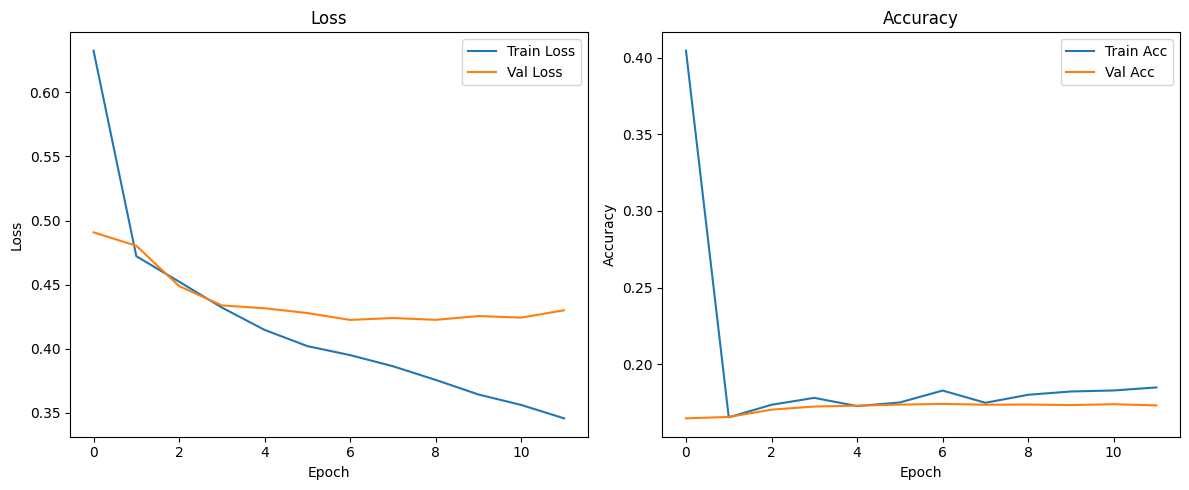

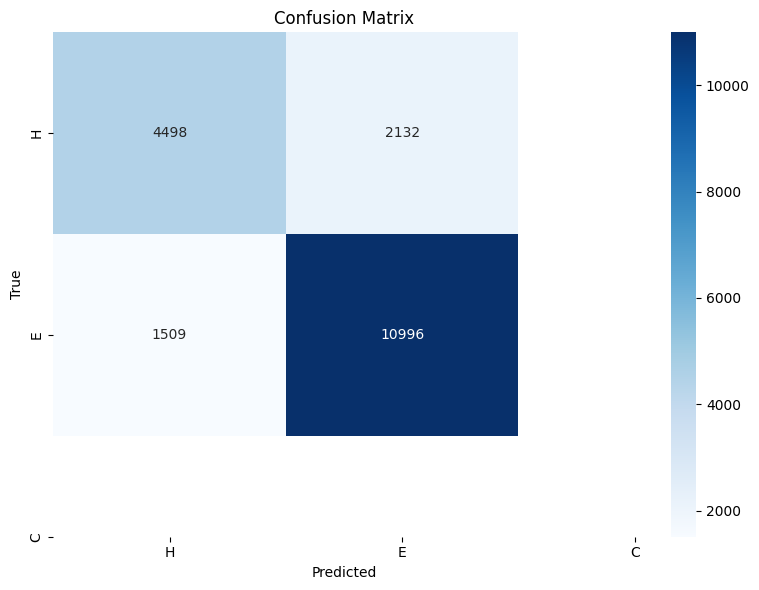

In [ ]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model (input_dim=20 for one-hot encoded amino acids)
model = BiLSTM(input_dim=20, hidden_dim=hidden_dim, output_dim=3, num_layers=num_layers, dropout=dropout)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
print("Training FASTA model...")
history, best_model_state = train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=num_epochs, patience=patience
)

# Load best model
model.load_state_dict(best_model_state)

# Evaluate model
print("Evaluating FASTA model...")
test_loss, test_acc, cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Save model
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/fasta_model.pt')
print("Model saved to models/fasta_model.pt")

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(cm)

# Train and evaluate PSSM model

Using device: cuda
Training PSSM model...
Epoch: 1/20, Batch: 10/27, Loss: 0.5458
Epoch: 1/20, Batch: 20/27, Loss: 0.5547
Epoch: 1/20, Train Loss: 0.6200, Train Acc: 0.1579, Val Loss: 0.5135, Val Acc: 0.1613
Epoch: 2/20, Batch: 10/27, Loss: 0.4837
Epoch: 2/20, Batch: 20/27, Loss: 0.4846
Epoch: 2/20, Train Loss: 0.4721, Train Acc: 0.1632, Val Loss: 0.4510, Val Acc: 0.1699
Epoch: 3/20, Batch: 10/27, Loss: 0.4685
Epoch: 3/20, Batch: 20/27, Loss: 0.4421
Epoch: 3/20, Train Loss: 0.4441, Train Acc: 0.1704, Val Loss: 0.4369, Val Acc: 0.1717
Epoch: 4/20, Batch: 10/27, Loss: 0.3969
Epoch: 4/20, Batch: 20/27, Loss: 0.4333
Epoch: 4/20, Train Loss: 0.4206, Train Acc: 0.1720, Val Loss: 0.4313, Val Acc: 0.1731
Epoch: 5/20, Batch: 10/27, Loss: 0.4100
Epoch: 5/20, Batch: 20/27, Loss: 0.4257
Epoch: 5/20, Train Loss: 0.4164, Train Acc: 0.1677, Val Loss: 0.4278, Val Acc: 0.1731
Epoch: 6/20, Batch: 10/27, Loss: 0.4308
Epoch: 6/20, Batch: 20/27, Loss: 0.4002
Epoch: 6/20, Train Loss: 0.4044, Train Acc: 0.17

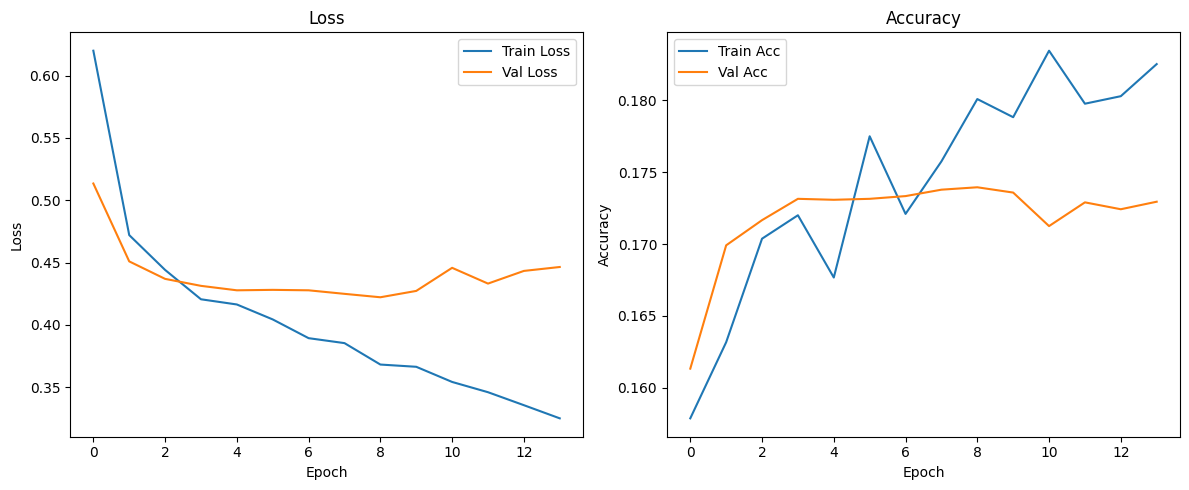

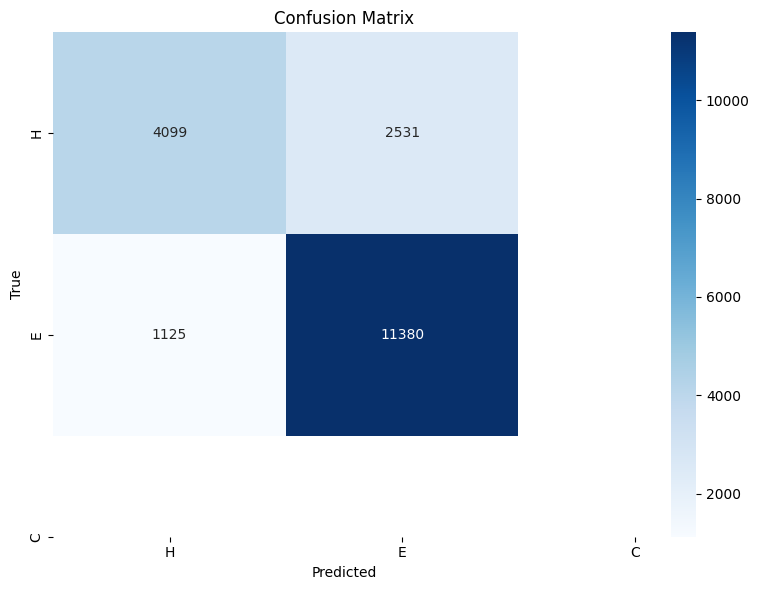

In [ ]:


# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model (input_dim=20 for PSSM)
model = BiLSTM(input_dim=20, hidden_dim=hidden_dim, output_dim=3, num_layers=num_layers, dropout=dropout)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
print("Training PSSM model...")
history, best_model_state = train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=num_epochs, patience=patience
)

# Load best model
model.load_state_dict(best_model_state)

# Evaluate model
print("Evaluating PSSM model...")
test_loss, test_acc, cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Save model
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/pssm_model.pt')
print("Model saved to models/pssm_model.pt")

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(cm)

# Compare models



Model Comparison:
FASTA model test accuracy: 0.8089
PSSM model test accuracy: 0.8089
Improvement with PSSM: 0.0000 (0.00%)


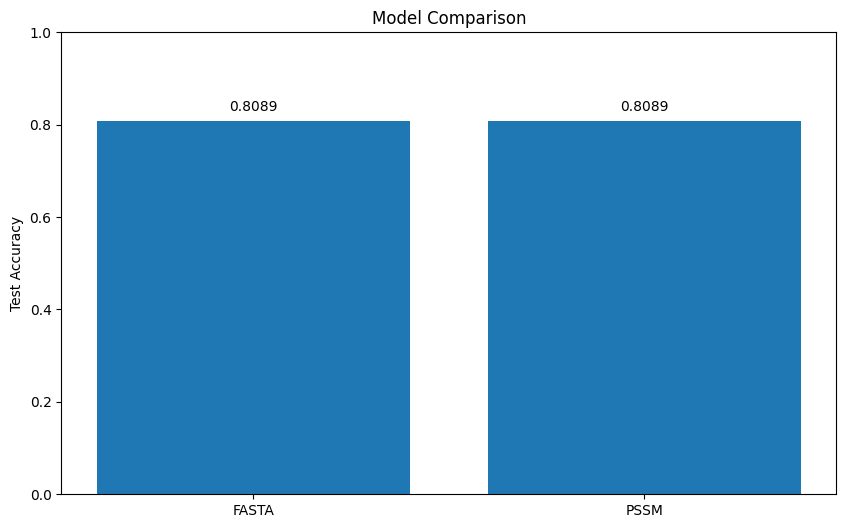

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

# Load results from saved models (if needed)
# You can also use the test_acc values from the previous cells

# Define variables to store accuracy values
fasta_acc = test_acc  # From FASTA model evaluation
pssm_acc = None  # Will be filled after PSSM model evaluation

# After running the PSSM model cell, update this value
pssm_acc = test_acc  # Uncomment this after running PSSM model

# Compare models
print("\nModel Comparison:")
print(f"FASTA model test accuracy: {fasta_acc:.4f}")
if pssm_acc is not None:
    print(f"PSSM model test accuracy: {pssm_acc:.4f}")

    # Calculate improvement
    improvement = pssm_acc - fasta_acc
    print(f"Improvement with PSSM: {improvement:.4f} ({improvement/fasta_acc*100:.2f}%)")

    # Plot comparison
    plt.figure(figsize=(10, 6))
    accuracies = [fasta_acc, pssm_acc]
    plt.bar(['FASTA', 'PSSM'], accuracies)
    plt.ylabel('Test Accuracy')
    plt.title('Model Comparison')
    plt.ylim([0, 1.0])

    # Add text labels
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')

    plt.show()
else:
    print("PSSM model not evaluated yet. Run the PSSM model cell first.")

    # Plot FASTA model only
    plt.figure(figsize=(10, 6))
    plt.bar(['FASTA'], [fasta_acc])
    plt.ylabel('Test Accuracy')
    plt.title('FASTA Model Accuracy')
    plt.ylim([0, 1.0])
    plt.text(0, fasta_acc + 0.02, f"{fasta_acc:.4f}", ha='center')
    plt.show()

# Prediction on new sequences

<ipython-input-14-bcfea644c4a5>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Example protein sequence:
MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG

Predicted secondary structure:
CCCCCCCCEEEEEEECCCCCCCCCCCCCCCCCECCCCCCCCCCCCCCCCEECCCCCCCCCCCCCCEEEEEEECCCCCCCCCCCCCCCCEEEECCCCCCCCCEEEEEECCCCCCCEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCEECCCCCCC


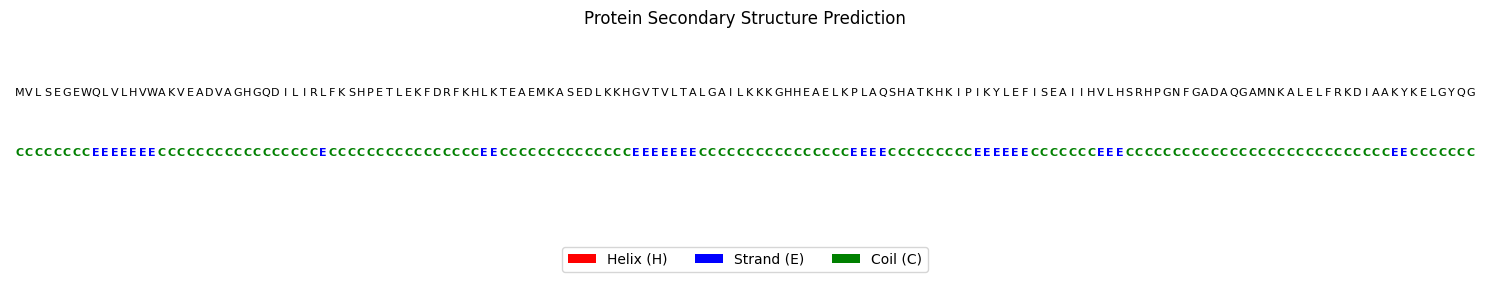

In [ ]:
# Function to predict secondary structure for a new sequence
def predict_secondary_structure(sequence, model_path, device, input_type='fasta'):
    """
    Predict secondary structure for a new protein sequence
    Args:
        sequence: Amino acid sequence (string) or PSSM matrix
        model_path: Path to the saved model
        device: Device to run the model on
        input_type: 'fasta' or 'pssm'
    Returns:
        Predicted secondary structure (string)
    """
    # Load model
    model = BiLSTM(input_dim=20, hidden_dim=128, output_dim=3, num_layers=2, dropout=0.5)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # Prepare input
    if input_type == 'fasta':
        # One-hot encode the sequence
        aa_to_idx = {
            'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
            'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
            'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19
        }
        encoded = np.zeros((len(sequence), 20))
        for i, aa in enumerate(sequence):
            if aa in aa_to_idx:
                encoded[i, aa_to_idx[aa]] = 1
    else:  # PSSM
        encoded = sequence  # Already in correct format

    # Convert to tensor
    encoded_tensor = torch.FloatTensor(encoded).unsqueeze(0)  # Add batch dimension
    lengths = torch.LongTensor([encoded_tensor.size(1)])  # Sequence length

    # Predict
    with torch.no_grad():
        encoded_tensor = encoded_tensor.to(device)
        lengths = lengths.to(device)
        output = model(encoded_tensor, lengths)
        _, predicted = torch.max(output.squeeze(0), 1)

    # Convert to secondary structure string
    idx_to_ss = {0: 'H', 1: 'E', 2: 'C'}
    ss_prediction = ''.join([idx_to_ss[idx.item()] for idx in predicted])

    return ss_prediction

# Example usage
if os.path.exists('models/fasta_model.pt'):
    # Example sequence (replace with your own)
    example_sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

    # Predict secondary structure
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ss_prediction = predict_secondary_structure(example_sequence, 'models/fasta_model.pt', device, input_type='fasta')

    # Print results
    print("Example protein sequence:")
    print(example_sequence)
    print("\nPredicted secondary structure:")
    print(ss_prediction)

    # Visualize the prediction
    plt.figure(figsize=(15, 3))

    # Plot sequence
    for i, aa in enumerate(example_sequence):
        plt.text(i, 0.5, aa, ha='center', va='center', fontsize=8)

    # Plot secondary structure with colors
    for i, ss in enumerate(ss_prediction):
        if ss == 'H':
            color = 'red'
        elif ss == 'E':
            color = 'blue'
        else:  # 'C'
            color = 'green'
        plt.text(i, 0, ss, ha='center', va='center', fontsize=8, color=color, weight='bold')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Helix (H)'),
        Patch(facecolor='blue', label='Strand (E)'),
        Patch(facecolor='green', label='Coil (C)')
    ]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.xlim(-1, len(example_sequence))
    plt.ylim(-0.5, 1)
    plt.axis('off')
    plt.title('Protein Secondary Structure Prediction')
    plt.tight_layout()
    plt.show()
else:
    print("Model not found. Train the model first.")